In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

In [2]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

In [3]:
max_component_num = 500
max_bezier_curve_num = 10000

image = cv2.imread('images/truck.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(model=sam,
    points_per_side=32,
    pred_iou_thresh=0.86,
    stability_score_thresh=0.92,
    crop_n_layers=1,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=100)
masks = mask_generator.generate(image)

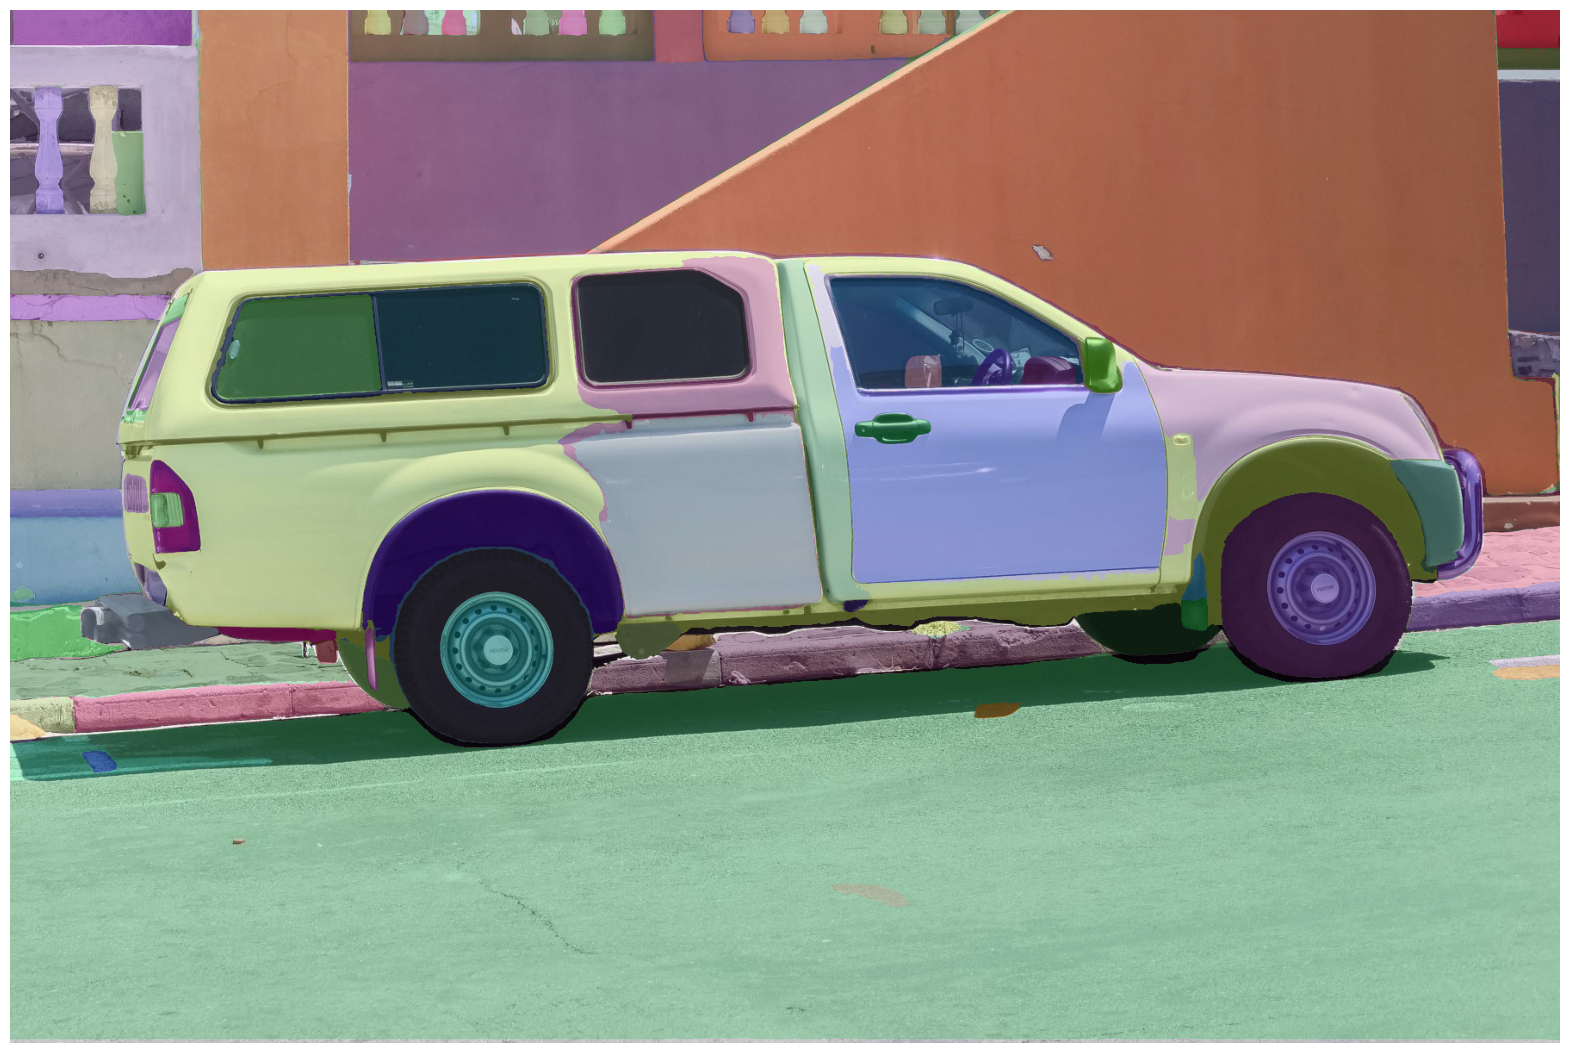

In [4]:
plt.figure(figsize=(20,20))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.show() 

In [5]:
import numpy as np
from scipy.linalg import lstsq
from scipy.spatial import distance

def compute_arc_length_params(points):
    """
    計算弧長參數化的參數 t_i
    :param points: 样本点列表 [(x0, y0), (x1, y1), ..., (xn, yn)]
    :return: 弧长参数化后的参数列表 [t0, t1, ..., tn]
    """
    n = len(points)
    dists = [np.linalg.norm(np.array(points[i]) - np.array(points[i-1])) for i in range(1, n)]
    s = [0] + np.cumsum(dists).tolist()
    total_length = s[-1]
    t = [si / total_length for si in s]
    return t

def fit_bezier_curve(points):
    """
    拟合三次贝塞尔曲线
    :param points: 样本点列表 [(x0, y0), (x1, y1), ..., (xn, yn)]
    :return: 控制点 [(P0x, P0y), (P1x, P1y), (P2x, P2y), (P3x, P3y)]
    """
    points = np.array(points)
    t = compute_arc_length_params(points)
    
    # 设定 P0 和 P3
    P0 = points[0]
    P3 = points[-1]
    
    # 构建矩阵 A 和向量 B
    A = []
    Bx = []
    By = []
    
    for i in range(1, len(points) - 1):
        ti = t[i]
        A.append([3 * (1 - ti)**2 * ti, 3 * (1 - ti) * ti**2])
        Bx.append(points[i, 0] - ((1 - ti)**3 * P0[0] + ti**3 * P3[0]))
        By.append(points[i, 1] - ((1 - ti)**3 * P0[1] + ti**3 * P3[1]))
    
    A = np.array(A)
    Bx = np.array(Bx)
    By = np.array(By)
    
    # 解最小二乘问题
    Px, _, _, _ = lstsq(A, Bx)
    Py, _, _, _ = lstsq(A, By)
    
    P1 = (Px[0], Py[0])
    P2 = (Px[1], Py[1])
    
    return [tuple(P0), P1, P2, tuple(P3)],t

def bezier_curve(t, p0, p1, p2, p3):
    """
    计算贝塞尔曲线上的点
    :param t: 参数t（0到1之间）
    :param p0: 控制点P0
    :param p1: 控制点P1
    :param p2: 控制点P2
    :param p3: 控制点P3
    :return: 贝塞尔曲线上的点
    """
    return (1-t)**3 * p0 + 3*(1-t)**2 * t * p1 + 3*(1-t) * t**2 * p2 + t**3 * p3

def compute_approximation_error(points, control_points, points_t):
    """
    计算逼近误差
    :param points: 样本点列表 [(x0, y0), (x1, y1), ..., (xn, yn)]
    :param control_points: 控制点列表 [(P0x, P0y), (P1x, P1y), (P2x, P2y), (P3x, P3y)]
    :return: 逼近误差
    """
    total_error = 0
    n = len(points)
    
    # 遍历样本点
    for point, t in zip(points,points_t):
        curve_point = bezier_curve(t, *control_points)
        dist = distance.euclidean(point, curve_point)
        total_error +=dist
    
    return total_error

def fit_bezier_curve_and_error(points):
    control_points,points_t = fit_bezier_curve(points)
    loss=compute_approximation_error(points,np.array(control_points),points_t)
    return control_points,loss

def mask_to_contours(mask):
    mask = mask.astype(np.uint8)*255
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    contours_points = []
    filled_masks_area = []
    filled_masks = []
    for contour in contours:
        filled_mask = np.zeros(mask.shape, dtype=np.uint8)
        cv2.drawContours(filled_mask, [contour], -1, (1), thickness=cv2.FILLED)
        filled_masks.append(filled_mask)
        filled_masks_area.append(np.sum(filled_mask))
        contours_points.append(np.concatenate([contour[:, 0, :],contour[:1, 0, :]],0))
    return contours_points,filled_masks,filled_masks_area

In [6]:
new_masks=[]
for i in range(len(masks)):
    m = masks[i]['segmentation']
    contours_points,filled_masks,filled_masks_area=mask_to_contours(m)
    for i in range(len(contours_points)):
        ma = dict()
        ma["contours_points"] = contours_points[i]
        ma["filled_mask"] = filled_masks[i]
        ma["filled_mask_area"] = filled_masks_area[i]
        new_masks.append(ma)
sorted_masks = sorted(new_masks, key=(lambda x: x['filled_mask_area']), reverse=True)[:max_component_num]


In [7]:
# 優化bezier_curve
use_bezier_curve_num = 0
for ma in sorted_masks:
    control_points,loss=fit_bezier_curve_and_error(ma["contours_points"])
    control_points_set = dict()
    control_points_set["control_points"]=control_points
    control_points_set["loss"]=loss
    control_points_set["range"]=[0,len(ma["contours_points"])-1]
    ma["control_points_sets"]=[control_points_set]
    use_bezier_curve_num+=1
    if use_bezier_curve_num>=max_bezier_curve_num:
        break
y=0
while use_bezier_curve_num<max_bezier_curve_num:
    y+=1
    max_loss_control_points_set = sorted_masks[0]["control_points_sets"][0]
    max_loss_ma_index = 0
    max_loss_ma_control_points_sets_index = 0
    for i1,ma in enumerate(sorted_masks):
        for i2,control_points_set in enumerate(ma["control_points_sets"]):
            if control_points_set["loss"]>max_loss_control_points_set["loss"]:
                max_loss_control_points_set = control_points_set
                max_loss_ma_index = i1
                max_loss_ma_control_points_sets_index = i2
    if max_loss_control_points_set["range"][1]-max_loss_control_points_set["range"][0]<8:
        print("out",y)
        break
    ma = sorted_masks[max_loss_ma_index]
    sorted_masks[max_loss_ma_index]["control_points_sets"].pop(max_loss_ma_control_points_sets_index)
    control_points_set = dict()
    mt=int((max_loss_control_points_set["range"][0]+max_loss_control_points_set["range"][1])//2)
    t1=max_loss_control_points_set["range"][0]
    t2=mt
    control_points,loss=fit_bezier_curve_and_error(ma["contours_points"][t1:t2])
    control_points_set["control_points"]=control_points
    control_points_set["loss"]=loss
    control_points_set["range"]=[t1,t2]
    ma["control_points_sets"].insert(max_loss_ma_control_points_sets_index,control_points_set)
    control_points_set = dict()
    t1=mt
    t2=max_loss_control_points_set["range"][1]
    control_points,loss=fit_bezier_curve_and_error(ma["contours_points"][t1:t2])
    control_points_set["control_points"]=control_points
    control_points_set["loss"]=loss
    control_points_set["range"]=[t1,t2]
    ma["control_points_sets"].insert(max_loss_ma_control_points_sets_index+1,control_points_set)

out 6261


In [8]:
# 決定顏色
sorted_masks.reverse()
image_color_mask = np.ones(sorted_masks[0]["filled_mask"].shape)
for i,ma in enumerate(sorted_masks):
    tm = image_color_mask*ma["filled_mask"]
    sorted_masks[i]["color"] = np.sum(image * np.expand_dims(tm,2),(0,1))/np.sum(tm)
    image_color_mask = image_color_mask * (1-ma["filled_mask"])
sorted_masks.reverse()

In [10]:
def write_svg(filename,sorted_masks):
    with open(filename, 'w') as f:
        f.write('<svg xmlns="http://www.w3.org/2000/svg" width="'+str(image.shape[1])+'" height="'+str(image.shape[0])+'" viewbox="0 0 '+str(image.shape[1])+' '+str(image.shape[0])+'">\n')
        for ma in sorted_masks:
            control_points_sets = ma["control_points_sets"]
            rgb = ma["color"]
            control_points = control_points_sets[0]["control_points"]
            f.write('<path d="M {:.2f} {:.2f} '.format(control_points[0][0], control_points[0][1]))
            for control_points_set in control_points_sets:
                control_points = control_points_set["control_points"]
                f.write('C {:.2f} {:.2f}, {:.2f} {:.2f}, {:.2f} {:.2f} '.format(control_points[1][0], control_points[1][1],control_points[2][0], control_points[2][1], control_points[3][0],control_points[3][1]))
            f.write('Z" fill="rgb('+str(rgb[0])+','+str(rgb[1])+','+str(rgb[2])+')" />\n')
        f.write('</svg>')
write_svg('bezier_curves.svg', sorted_masks)